# OCR for License Plate

In [1]:
import os
import cv2
import glob

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline
matplotlib.font_manager._rebuild()

In [2]:
# lp_fn_list = glob.glob('/home/yoyo/Desktop/alpr-unconstrained/result/test-detector/*_*car_lp.png')
lp_fn_list = glob.glob('sample_lp/*_*car_lp.png')

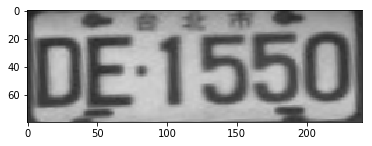

In [3]:
import random
lp_fn = random.choice(lp_fn_list)
lp_im = cv2.imread(lp_fn)
plt.imshow(lp_im)

## Character Segmentation

1. Adaptive Thresholding on greyscale image.

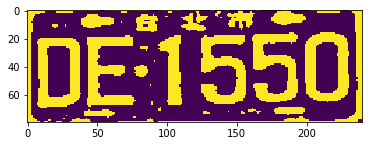

In [4]:
lp_im_grey = cv2.cvtColor(lp_im, cv2.COLOR_BGR2GRAY)
th3 = cv2.adaptiveThreshold(lp_im_grey,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                            cv2.THRESH_BINARY_INV,11,3)
plt.imshow(th3)

2. Connected component on pixels

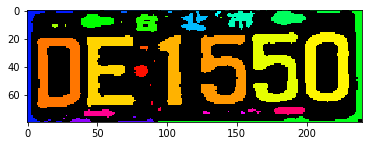

In [5]:
ret, labels = cv2.connectedComponents(th3)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)
imshow_components(labels)

3. Crop characters by using the bounding box of connected components and filter based on ink amount, ink-to-area ratio, aspect ratio, and area.

(0.5309090909090909, 33, 50, 876, 1650, 0.66)
(0.5475, 32, 50, 876, 1600, 0.64)
(0.47843137254901963, 35, 51, 854, 1785, 0.6862745098039216)
(0.5576470588235294, 17, 50, 474, 850, 0.34)
(0.548469387755102, 32, 49, 860, 1568, 0.6530612244897959)
(0.54125, 32, 50, 866, 1600, 0.64)


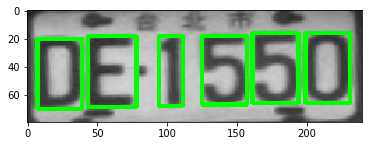

In [6]:
def findbox(bw):
    rows = np.any(bw, axis=1)
    cols = np.any(bw, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    x = cmin
    y = rmin
    w = cmax - cmin + 1
    h = rmax - rmin + 1
    return x, y, w, h
    

bbox = []
for i in range(1,ret):
    x, y, w, h = findbox(labels==i)
    a = (labels==i).sum()
    ratio = w/float(h)
    if a < 100 or a/float(w*h) < 0.1 or ratio > 10 or (w*h) > 5000 or h < 20:
        continue
    print(a/float(w*h), w, h, a, w*h, w/float(h))
    bbox.append((x,y,w,h))

lp_bbox = lp_im.copy()
for x, y, w, h in bbox:
    cv2.rectangle(lp_bbox,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(lp_bbox)

## Character Recognition

1. Generate template (all possible characters in license plates)

In [7]:
from PIL import Image, ImageDraw, ImageFont

if not os.path.exists('lp_char'):
    os.makedirs('lp_char')
x = 0

c = range(0x0E01, 0x0E2F) + range(65, 91) + range(48, 58)
c.remove(0x0E24)
c.remove(0x0E26)
for i in c:
    print unichr(i),
    
    img = Image.new('RGB', (64, 64))
    draw = ImageDraw.Draw(img)
    # font = ImageFont.truetype(<font-file>, <font-size>)
    font = ImageFont.truetype("Sarun's ThangLuang.ttf", 66)
    # draw.text((x, y),"Sample Text",(r,g,b))
    w, h = draw.textsize(unichr(i), font=font)
    draw.text(((64-w)/2,-46),unichr(i),(255,255,255),font=font)
    img.save('lp_char/%02d.png' % x)
    x += 1

ก ข ฃ ค ฅ ฆ ง จ ฉ ช ซ ฌ ญ ฎ ฏ ฐ ฑ ฒ ณ ด ต ถ ท ธ น บ ป ผ ฝ พ ฟ ภ ม ย ร ล ว ศ ษ ส ห ฬ อ ฮ A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 0 1 2 3 4 5 6 7 8 9


2. Pre-load all the templates and resize it to match the license plate size

In [8]:
from scipy.stats import tmean
arr = np.array([b[3] for b in bbox])
print '%f +/- %f' % (arr.mean(), arr.std())
h_char = tmean(arr, (arr.mean()-arr.std(), arr.mean()+arr.std()))
print h_char

50.000000 +/- 0.577350
50.0


In [9]:
char_fn_list = sorted(glob.glob('lp_char/*.png'))
chlist = []
for char_fn in char_fn_list:
    im = cv2.imread(char_fn)
    im_grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    x, y, w, h = findbox(im_grey > 100)
    
    scale = h_char/h
    width = int(w * scale)
    height = int(h * scale)
    dim = (width, height)
    resized = cv2.resize(255 - im_grey[y:y+h, x:x+w], dim, interpolation = cv2.INTER_AREA)

    chlist.append(resized)

3. Match template using sliding window (https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html)

Find all candidates, which are peak local maximums that match the bounding boxes (by comparing their top-left position).

In [10]:
from skimage.feature import peak_local_max

def tup_dist(a,b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

cand = [[] for i in range(len(bbox))]
for i, template in enumerate(chlist):
    res = cv2.matchTemplate(lp_im_grey, template, cv2.TM_CCOEFF)
    coordinates = peak_local_max(res, min_distance=5, num_peaks=5)
    for y, x in coordinates:
        for k, bb in enumerate(bbox):
            dis = tup_dist(bb[:2], (x,y))
            if dis < 7:
                cand[k].append((res[y,x], (x,y), unichr(c[i]), dis))
cand = [sorted(cnd, key=lambda x: x[0], reverse=True)[:5] for cnd in cand]

In [11]:
cand

[[(7156136.0, (162, 18), u'5', 2.23606797749979),
  (6277930.0, (160, 16), u'\u0e13', 1.0),
  (5106759.0, (157, 16), u'\u0e29', 4.0),
  (4839774.0, (161, 15), u'8', 1.0),
  (4832184.0, (162, 15), u'S', 1.4142135623730951)],
 [(8592469.0, (197, 16), u'O', 2.0),
  (7844263.5, (198, 16), u'0', 1.0),
  (7491792.5, (201, 16), u'D', 2.0),
  (7466347.5, (195, 14), u'\u0e20', 4.47213595499958),
  (7380911.0, (194, 18), u'\u0e1a', 5.385164807134504)],
 [(8475695.0, (45, 19), u'E', 2.23606797749979),
  (7039391.5, (45, 17), u'F', 2.23606797749979),
  (6304929.0, (45, 20), u'L', 2.8284271247461903),
  (6092172.5, (45, 16), u'P', 2.8284271247461903),
  (5959576.0, (46, 19), u'B', 3.1622776601683795)],
 [(7181369.5, (90, 20), u'T', 4.47213595499958),
  (6442778.0, (96, 20), u'\u0e1a', 2.8284271247461903),
  (5921561.5, (98, 13), u'\u0e20', 6.4031242374328485),
  (5852887.5, (95, 17), u'\u0e17', 1.4142135623730951),
  (5567232.5, (96, 17), u'\u0e2b', 2.23606797749979)],
 [(7125718.0, (125, 19), u'5'

4. Filter candidates by picking only the match with highest score.

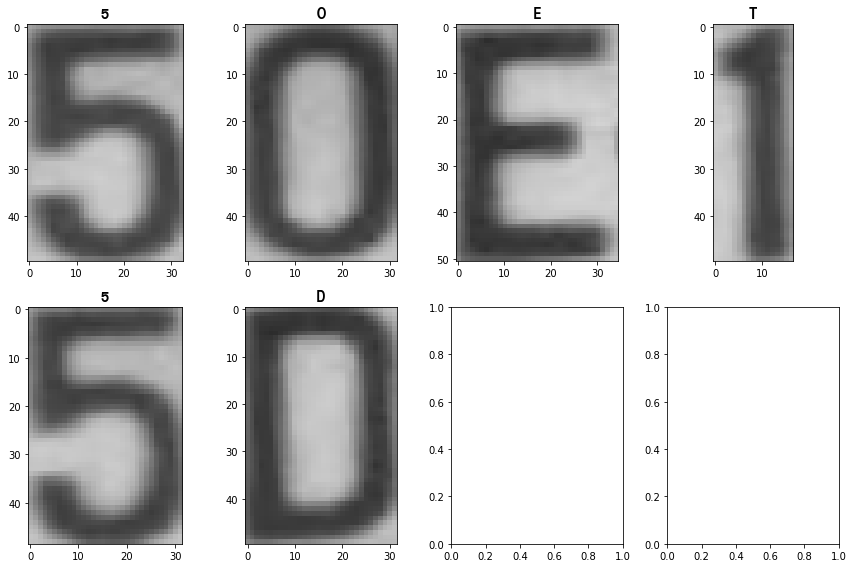

In [12]:
nrow = np.ceil(len(bbox) / 4.0).astype('int32')
fig, axes = plt.subplots(nrows=nrow, ncols=4, figsize=(12, nrow*4))
ax = axes.ravel()

for i, ((x,y,w,h), cnd) in enumerate(zip(bbox,cand)):
    lp_char = lp_im[y:y+h, x:x+w]
    ax[i].imshow(lp_char, cmap=plt.cm.gray)
    
    if cnd != []:
        ax[i].set_title(cnd[0][2], fontsize=16, fontproperties = FontProperties("Sarun's ThangLuang"))
fig.tight_layout()
plt.show()